<a href="https://colab.research.google.com/github/lizzzb/Collaborative-Filtering-Algo-for-RecommenderSystems/blob/main/SAR_for_CF_from_RecommendersGitHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAR Single Node on MovieLens (Python, CPU)

**Simple Algorithm for Recommendation (SAR) is a fast and scalable algorithm for personalized recommendations based on user transaction history. It produces easily explainable and interpretable recommendations and handles "cold item" and "semi-cold user" scenarios.**

In this example, we will walk through each step of the Simple Algorithm for Recommendation (SAR) algorithm using a Python single-node implementation.

SAR is a fast, scalable, adaptive algorithm for personalized recommendations based on user transaction history. It is powered by understanding the similarity between items, and recommending similar items to those a user has an existing affinity for.

## 1 SAR algorithm

The following figure presents a high-level architecture of SAR.

At a very high level, **two intermediate matrices are created and used to generate a set of recommendation scores**:

- An **item similarity matrix** $S$ estimates **item-item relationships**.
- An **affinity matrix** $A$ estimates **user-item relationships**.

Recommendation scores are then created by computing the **matrix multiplication** $A\times S$.

Optional steps (e.g. "time decay" and "remove seen items") are described in the details below.

<img src="https://recodatasets.z20.web.core.windows.net/images/sar_schema.svg?sanitize=true">

### 1.1 Compute item co-occurrence and item similarity

**SAR defines similarity based on item-to-item co-occurrence data.** Co-occurrence is defined as the number of times two items appear together for a given user. We can represent the co-occurrence of all items as a $m\times m$ matrix $C$, where $c_{i,j}$ is the number of times item $i$ occurred with item $j$, and $m$ is the total number of items.

The co-occurence matric $C$ has the following properties:

- It is **symmetric**, so $c_{i,j} = c_{j,i}$
- It is **nonnegative**: $c_{i,j} \geq 0$
- The occurrences are at least as large as the co-occurrences. I.e., the largest element for each row (and column) is on the main diagonal: $\forall(i,j) C_{i,i},C_{j,j} \geq C_{i,j}$.


The condition $C_{i,i},C_{j,j} \geq C_{i,j}$​ suggests the following:

- Self-Occurrences:
  - $C_{i,i}$​ represents the total number of occurrences of item i alone (e.g., how many times item ii was purchased or rated).
  - $C_{j,j}$​ similarly represents the occurrences of item j.

- Co-occurrences:
  - $C_{i,j}$​ indicates how often items ii and jj are co-occurring together.

The condition ensures that the occurrences of items on their own (the diagonal elements) are at least as large as the occurrences of the items together.

Once we have a co-occurrence matrix, an item similarity matrix $S$ can be obtained by **rescaling the co-occurrences according to a given metric**. Options for the metric include `Jaccard`, `lift`, and `counts` (meaning no rescaling).


If $c_{ii}$ and $c_{jj}$ are the $i$th and $j$th diagonal elements of $C$, the rescaling options are:

- `Jaccard`: $s_{ij}=\frac{c_{ij}}{(c_{ii}+c_{jj}-c_{ij})}$
- `lift`: $s_{ij}=\frac{c_{ij}}{(c_{ii} \times c_{jj})}$
- `counts`: $s_{ij}=c_{ij}$

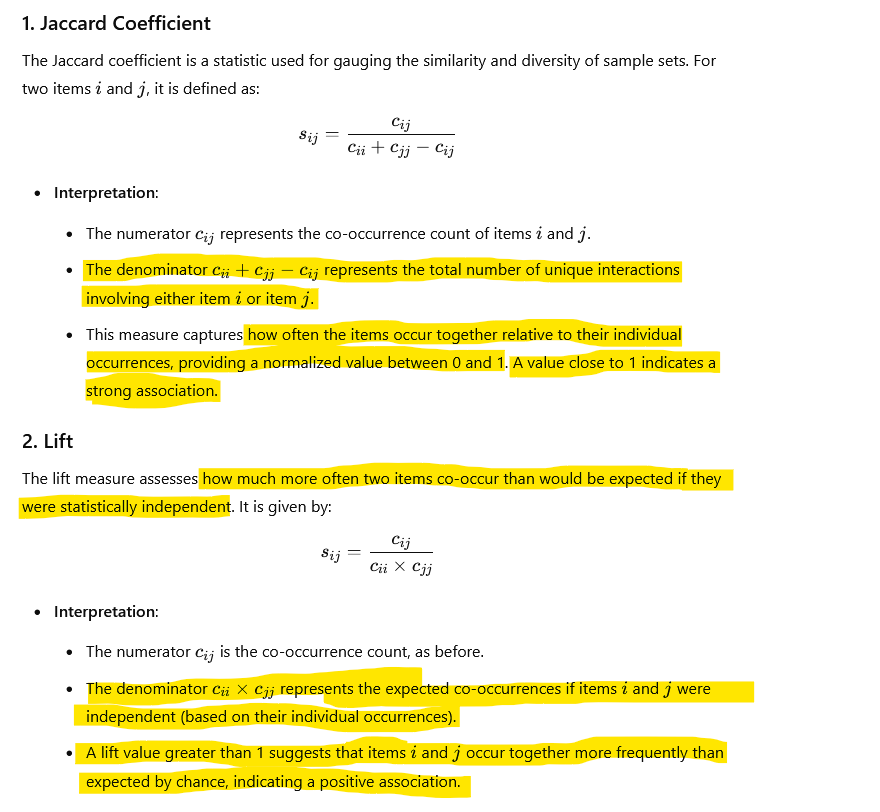


In general, using `counts` as a similarity metric favours **predictability, meaning that the most popular items will be recommended most of the time (POPULARITY BIAS)**.

`lift` by contrast favours **discoverability/serendipity**: an item that is less popular overall but highly favoured by a small subset of users is more likely to be recommended.

`Jaccard` is a compromise between the two.


### 1.2 Compute user affinity scores

The affinity matrix in SAR captures **the strength of the relationship between each individual user and the items that user has already interacted with**. SAR incorporates two factors that can impact users' affinities:

- It can consider information about the **type** of user-item interaction through **differential weighting of different events** (e.g. it may weigh events in which a user rated a particular item more heavily than events in which a user viewed the item).
- It can consider information about **when** a user-item event occurred (e.g. it may discount the value of events that take place in the distant past.

Formalizing these factors produces us an expression for user-item affinity:

$$a_{ij}=\sum_k w_k \left(\frac{1}{2}\right)^{\frac{t_0-t_k}{T}} $$

where the affinity $a_{ij}$ for user $i$ and item $j$ is the weighted sum of all $k$ events involving user $i$ and item $j$. $w_k$ represents the weight of a particular event, and the power of 2 term reflects the temporally-discounted event. The $(\frac{1}{2})^n$ scaling factor causes the parameter $T$ to serve as a half-life: events $T$ units before $t_0$ will be given half the weight as those taking place at $t_0$.

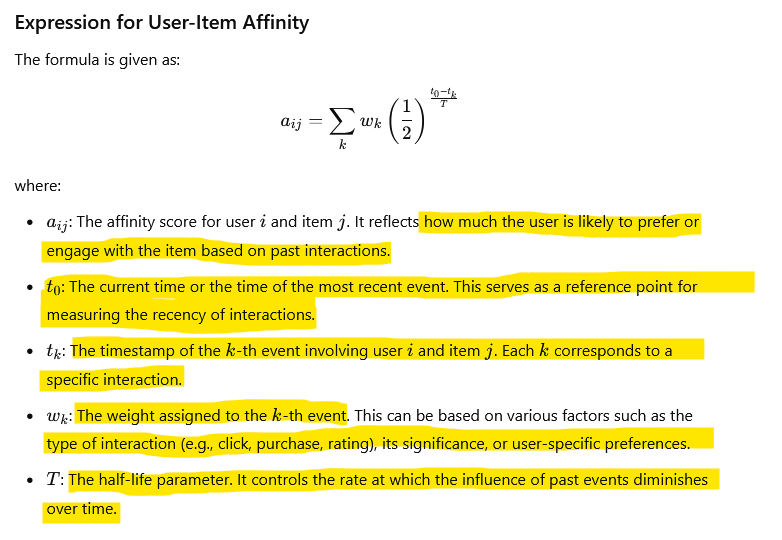

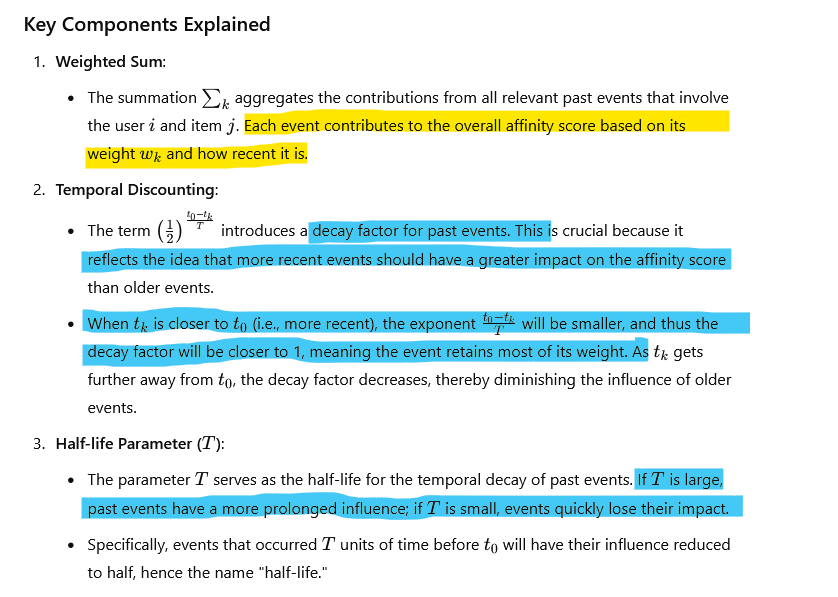


Repeating this computation for all $n$ users and $m$ items results in an $n\times m$ matrix $A$. Simplifications of the above expression can be obtained by setting all the weights equal to 1 (*effectively ignoring event types*), or by setting the half-life parameter $T$ to infinity (*ignoring transaction times*).

### 1.3 Remove seen item

Optionally we remove items which have already been seen in the training set, i.e. *don't recommend items which have been previously bought by the user again.*

### 1.4 Top-k item calculation

**The personalized recommendations for a set of users can then be obtained by multiplying the affinity matrix ($A$) by the similarity matrix ($S$).** The result is a recommendation score matrix, where each row corresponds to a user, each column corresponds to an item, and each entry corresponds to a user / item pair. **Higher scores correspond to more strongly recommended items.**

It is worth noting that the complexity of recommending operation depends on the data size. ** SAR algorithm itself has $O(n^3)$ complexity.** Therefore the single-node implementation is not supposed to handle large dataset in a scalable manner. Whenever one uses the algorithm, it is recommended to run with sufficiently large memory.

## 2 SAR single-node based movie recommender

In [1]:
!pip install recommenders

  Using cached pandera-0.20.4-py3-none-any.whl.metadata (15 kB)
Using cached pandera-0.20.4-py3-none-any.whl (259 kB)
  Attempting uninstall: pandera
    Found existing installation: pandera 0.7.1
    Uninstalling pandera-0.7.1:
      Successfully uninstalled pandera-0.7.1


In [2]:
!pip install pandera==0.7.1

  Using cached pandera-0.7.1-py3-none-any.whl.metadata (10 kB)
Using cached pandera-0.7.1-py3-none-any.whl (165 kB)
  Attempting uninstall: pandera
    Found existing installation: pandera 0.20.4
    Uninstalling pandera-0.20.4:
      Successfully uninstalled pandera-0.20.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
recommenders 1.2.0 requires pandera[strategies]>=0.15.0; python_version >= "3.9", but you have pandera 0.7.1 which is incompatible.


In [13]:
import pdb
import sys          # access to system-specific parameters and functions.
import logging      # flexible event logging for applications and libraries.
import scipy        # collection of mathematical algorithms and convenience functions
import numpy as np
import pandas as pd


from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.sar import SAR
from recommenders.utils.notebook_utils import store_metadata

print(f"System version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"SciPy version: {scipy.__version__}")

System version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
Pandas version: 2.2.2
NumPy version: 1.26.4
SciPy version: 1.13.1


In [14]:
# Top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = "100k"

In [34]:
logging.root.removeHandler
logging.getLogger('RootLogger').setLevel(logging.DEBUG)

logging.basicConfig(filename='app.log',
                    level=logging.DEBUG,
                    force=True, # Resets any previous configuration
                    )


    Level: logging.DEBUG - This means that log messages of severity DEBUG or higher will be recorded. The hierarchy of log levels is: DEBUG, INFO, WARNING, ERROR, CRITICAL.
    Format: "%(asctime)s %(levelname)-8s %(message)s" - This defines the structure of each log message. It includes the timestamp (asctime), log level name (levelname), and the actual message.
    Date Format: "%Y-%m-%d %H:%M:%S" - This specifies the format for displaying timestamps in the log messages.

This configuration sets up logging to capture detailed debugging information, along with timestamps, which can be helpful for troubleshooting and monitoring your code's execution.

### 3.1 Load Data

**SAR is intended to be used on interactions with the following schema:
`<User ID>, <Item ID>, <Time>`.**

**Each row represents a single interaction between a user and an item.** These interactions might be different types of events on an e-commerce website, such as a user clicking to view an item, adding it to a shopping basket, following a recommendation link, and so on.

The MovieLens dataset is well formatted interactions of Users providing Ratings to Movies (movie ratings are used as the event weight) - we will use it for the rest of the example.

In [30]:
data = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=["UserId", "MovieId", "Rating", "Timestamp"],
    title_col="Title",
)

# Convert the float precision to 32-bit in order to reduce memory consumption
data["Rating"] = data["Rating"].astype(np.float32)

data.head()

100%|██████████| 4.81k/4.81k [00:00<00:00, 18.3kKB/s]


,UserId,MovieId,Rating,Timestamp,Title
0,196,242,3.0,881250949,Kolya (1996)
1,186,302,3.0,891717742,L.A. Confidential (1997)
2,22,377,1.0,878887116,Heavyweights (1994)
3,244,51,2.0,880606923,Legends of the Fall (1994)
4,166,346,1.0,886397596,Jackie Brown (1997)


The header argument in movielens.load_pandas_df is typically used to specify the column names for the main data columns, such as user ID, movie ID, rating, and timestamp.

The title_col argument serves a distinct purpose – it indicates a separate column that contains movie titles. Including title_col directly within the header might lead to misinterpretation or errors during data loading.

### 3.2 Split the data using the python random splitter provided in utilities:

We split the full dataset into a `train` and `test` dataset to evaluate performance of the algorithm against a held-out set not seen during training. Because SAR generates recommendations based on user preferences, **all users that are in the test set must also exist in the training set.** For this case, we can use the provided `python_stratified_split` function which holds out a percentage (in this case 25%) of items from each user, but **ensures all users are in both `train` and `test` datasets**. Other options are available in the `dataset.python_splitters` module which provide more control over how the split occurs.


In [22]:
header = {
    "col_user": "UserId",
    "col_item": "MovieId",
    "col_rating": "Rating",
    "col_timestamp": "Timestamp",
    "col_prediction": "Prediction",
} # to ensure that the column names used within the SAR algorithm are consistent and clearly defined

In [23]:
train, test = python_stratified_split(data, ratio=0.75, col_user=header["col_user"], col_item=header["col_item"], seed=42)

In this case, for the illustration purpose, the following parameter values are used:

|Parameter|Value|Description|
|---------|---------|-------------|
|`similarity_type`|`jaccard`|Method used to calculate item similarity.|
|`time_decay_coefficient`|30|Period in days (term of $T$ shown in the formula of Section 1.2)|
|`time_now`|`None`|Time decay reference.|
|`timedecay_formula`|`True`|Whether time decay formula is used.|

`time_decay_coefficient (30)`: This parameter sets the period (in days) used for time decay, meaning that more recent interactions are weighted more heavily than older ones. A 30-day coefficient means that the model will prioritize interactions within the last month, giving more importance to recent user behavior. This can help capture users’ current preferences, making the recommendations more relevant.

`time_now (None)`: This parameter represents the reference time, typically the current time or the time the recommendation is generated. When set to None, it likely defaults to the time at which the recommendation is being made. If specified, it could allow for custom time references, useful for testing or evaluating recommendations at specific time intervals.

`timedecay_formula (True)`: Enabling timedecay_formula applies a time decay to the item interactions, meaning that older interactions will contribute less to the similarity calculation.

In [35]:

model = SAR(
    similarity_type="jaccard",
    time_decay_coefficient=30,
    time_now=None,
    timedecay_formula=True,
    **header                  #unpack the dictionary
)

model.fit(train)

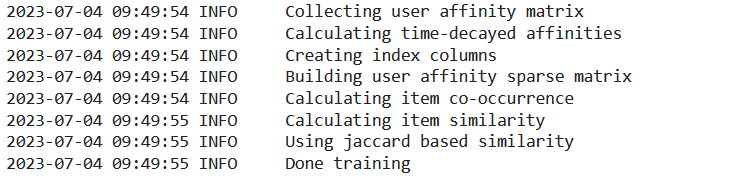

In [37]:
top_k = model.recommend_k_items(test, top_k=TOP_K, remove_seen=True)

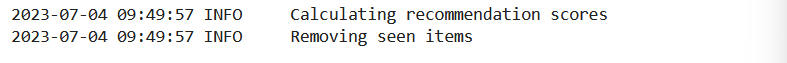

The final output from the `recommend_k_items` method generates recommendation scores for each user-item pair, which are shown as follows:

In [39]:
top_k_with_titles = top_k.join(
    data[["MovieId", "Title"]].drop_duplicates().set_index("MovieId"),
    on="MovieId",
    how="inner"
).sort_values(by=["UserId", "Prediction"], ascending=False)

top_k_with_titles.head(30)

,UserId,MovieId,Prediction,Title
9420,943,82,22.481977,Jurassic Park (1993)
9421,943,568,22.248813,Speed (1994)
9422,943,550,22.080580,Die Hard: With a Vengeance (1995)
9423,943,176,21.647137,Aliens (1986)
9424,943,96,21.213240,Terminator 2: Judgment Day (1991)
9425,943,144,20.768581,Die Hard (1988)
9426,943,265,20.762896,"Hunt for Red October, The (1990)"
9427,943,231,20.748540,Batman Returns (1992)
9428,943,423,20.571264,E.T. the Extra-Terrestrial (1982)
9429,943,97,20.566647,Dances with Wolves (1990)


### 3.3 Evaluate the results (Here: Ranking technics)

It should be known that the recommendation scores generated by multiplying the item similarity matrix $S$ and the user affinity matrix $A$ **DOES NOT** have the same scale with the original explicit ratings in the movielens dataset. That is to say, **SAR algorithm is meant for the task of *recommending relevent items to users* rather than *predicting explicit ratings for user-item pairs*.**

To this end, **ranking metrics like precision@k, recall@k, etc., are more applicable to evaluate SAR algorithm.** The following illustrates how to evaluate SAR model by using the evaluation functions provided in Recommenders library.

In [42]:
# all ranking metrics have the same arguments
args = [test, top_k]    # list of positional arguments passed to the ranking metric functions
kwargs = dict(          # keyword arguments, specifying additional details required by the ranking metrics.
  col_user="UserId",
    col_item="MovieId",
    col_rating="Rating",
    col_prediction="Prediction",
    relevancy_method="top_k",
    k=TOP_K,
)

eval_map = map_at_k(*args, **kwargs)
eval_ndcg = ndcg_at_k(*args, **kwargs)
eval_precision = precision_at_k(*args, **kwargs)
eval_recall = recall_at_k(*args, **kwargs)

/usr/local/lib/python3.10/dist-packages/recommenders/evaluation/python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
/usr/local/lib/python3.10/dist-packages/recommenders/evaluation/python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(
/usr/local/lib/python3.10/dist-packages/recommenders/evaluation/python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
/usr/local/lib/python3.10/dist-packages/recomm

In [41]:
print(f"Model:",
      f"Top K:\t\t {TOP_K}",
      f"MAP:\t\t {eval_map:f}",
      f"NDCG:\t\t {eval_ndcg:f}",
      f"Precision@K:\t {eval_precision:f}",
      f"Recall@K:\t {eval_recall:f}", sep='\n')

Model:
Top K:		 10
MAP:		 0.244722
NDCG:		 0.379533
Precision@K:	 0.331071
Recall@K:	 0.176837


1. **MAP@10 (Mean Average Precision at 10)**: `0.113796`
   - This value suggests that, on average, around 11.4% of the top 10 recommendations are relevant across all users. While MAP values can vary widely depending on the dataset, this score may indicate room for improvement in relevance.

2. **NDCG@10 (Normalized Discounted Cumulative Gain at 10)**: `0.384809`
   - NDCG@10 reflects the quality of ranking within the top 10 recommendations, where items that are both relevant and ranked higher contribute more to the score. A score of 0.3848 suggests that the model ranks some relevant items higher, but the ordering can likely be optimized further to increase relevance near the top of the list.

3. **Precision@10**: `0.331707`
   - Precision@10 is approximately 33.2%, meaning that one out of every three recommendations in the top 10 is relevant. This indicates a decent proportion of relevant items within the top recommendations, though this metric doesn’t account for how many relevant items were missed.

4. **Recall@10**: `0.182571`
   - Recall@10 indicates that around 18.3% of all possible relevant items for each user are present in the top 10 recommendations. This suggests that while some relevant items are included, a substantial portion may still be missing.